In [ ]:
from IPython.display import clear_output

In [ ]:
%pip install torch torchvision torchsummary
%pip install matplotlib
%pip install pillow

clear_output()

In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from torchvision import transforms
from torchvision.datasets import CIFAR10
import pandas as pd

from time import sleep

%matplotlib inline

## Let's download Cifar10 images

In [ ]:
# We're only using this to download dataset. we will manually create a dataset from downloaded files
data = CIFAR10(root='./datasets', train=True, download=True)

Files already downloaded and verified


In [ ]:
# We'll save some of the dataset images in a directory and make a csv of the paths and then make a custom dataloader from it.
num_images = 500
img_dir = 'images/'

if not os.path.isdir(img_dir):
  os.makedirs(img_dir)

img_paths = []
img_labels = []

for i in range(num_images):

  img, label = data[i]

  img_name = f'image_{i}.png'
  img_path = os.path.join(img_dir, img_name)

  img.save(img_path)

  img_paths.append(img_path)
  img_labels.append(label)

img_df = pd.DataFrame({
    'img_path': img_paths,
    'label': img_labels
})

In [ ]:
img_df.head()

,img_path,label
0,images/image_0.png,6
1,images/image_1.png,9
2,images/image_2.png,9
3,images/image_3.png,4
4,images/image_4.png,1


In [ ]:
# Custom dataset

class CustomImageDataset(Dataset):  # needs to inherit dataset

  def __init__(self, df: pd.DataFrame, img_transforms=None, invert=False):  # Can take any parameters here

    self.df = df
    self.img_transforms = img_transforms
    self.invert = invert

  def __len__(self):

    return len(self.df)  # working with a dataframe helps us here

  def __getitem__(self, idx):

    df_row = self.df.iloc[idx]

    img_path  = df_row['img_path']
    img_label = df_row['label']  # Don't need label in our case but we'll still implement it completely

    img = Image.open(img_path)
    img_tensor = transforms.functional.to_tensor(img)

    if self.img_transforms is not None:
      img_tensor = self.img_transforms(img_tensor)

    if self.invert:
      img_tensor = (1-img_tensor) if img_tensor.dtype == torch.float else (255-img_tensor)

    return img_tensor, img_label

In [ ]:
# Let's see our custom invert and transforms functionality in action

resize_transforms = transforms.Resize((200, 200), antialias=None)

non_invert_ds = CustomImageDataset(img_df[:5], img_transforms=resize_transforms)  # just 5 is enough, we're just testing
invert_ds = CustomImageDataset(img_df[:5], img_transforms=resize_transforms, invert=True)  # just 5 is enough, we're just testing

# non_invert_ds = torch.cat(non_invert_ds)

In [ ]:
non_inv_imgs = [non_invert_ds[i][0] for i in range(3)]
inv_imgs = [invert_ds[i][0] for i in range(3)]

non_inv_imgs = torch.cat(non_inv_imgs, dim=2)
inv_imgs = torch.cat(inv_imgs, dim=2)

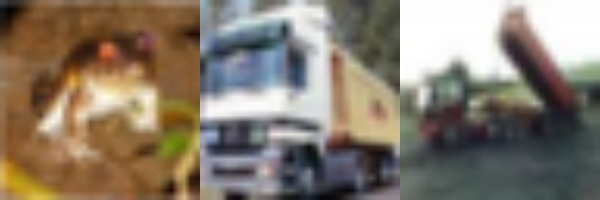

In [ ]:
transforms.functional.to_pil_image(non_inv_imgs)

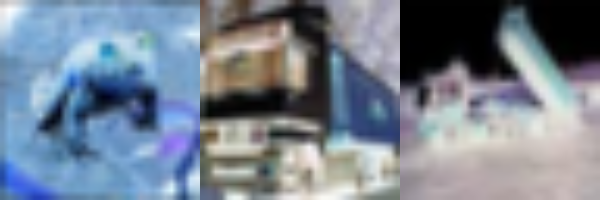

In [ ]:
transforms.functional.to_pil_image(inv_imgs)

## DataLoaders vs No DataLoaders

Speed comparison between both


In [ ]:
img_dataset = CustomImageDataset(img_df, img_transforms=resize_transforms)

# Let's make a dataloader first

batch_size = 64
img_loader = DataLoader(img_dataset, batch_size=batch_size, num_workers=2)

In [ ]:
print('Size of img_dataloader: ', len(img_loader))  # size of dataloader is the number of batches. 500/8 = 7.8 => ceil => 8
print('Size of dataset inside img_dataloader: ', len(img_loader.dataset))

Size of img_dataloader:  8
Size of dataset inside img_dataloader:  500


In [ ]:
# Now let's make a class to iterate the dataset manually

class ImageDatasetIterator:

  def __init__(self, dataset, batch_size=1):

    self.dataset = dataset
    self.batch_size = batch_size

  def __iter__(self):

    self.batch_no = 0
    return self

  def __next__(self):

    starting_idx = self.batch_no*self.batch_size
    ending_idx = starting_idx + self.batch_size

    if starting_idx >= len(self.dataset):
      raise StopIteration

    self.batch_no += 1

    if ending_idx >= len(self.dataset):
      ending_idx = len(self.dataset)

    imgs = []
    labels = []

    for i in range(starting_idx, ending_idx):

      img, label = self.dataset[i]
      imgs.append(img)
      labels.append(label)

    return torch.stack(imgs), torch.Tensor(labels)


batch_iterator = iter(ImageDatasetIterator(img_dataset, batch_size=batch_size))

Let's see how much time difference is over 20 epochs.

We'll add 0.2 second sleep which will be placeholder for training loop functinoality

In [ ]:
n_epochs = 20
sleep_time_sec = 0.2

Dataloader time

In [ ]:
%%time
for epoch_no in range(n_epochs):
  for _ in img_loader:
    sleep(sleep_time_sec)
  print(f'epoch {epoch_no}')

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
CPU times: user 714 ms, sys: 1.84 s, total: 2.56 s
Wall time: 45.3 s


In [ ]:
%%time
for epoch_no in range(n_epochs):
  for _ in batch_iterator:
    sleep(sleep_time_sec)
  print(f'epoch {epoch_no}')

CPU times: user 24 s, sys: 1.38 s, total: 25.3 s
Wall time: 57.5 s
